In [49]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import gc
import math
from sklearn.metrics import r2_score 

In [50]:
#Params
input_size= 400
batch_size= 512
nbr_epochs= 10
data_split_ratio=0.8
chunksize = 1000000
lr = 0.000001
save_model_epochs = [5]
model_name = "models/Swedbank"
y_column = "5s"
files_x = ["../python-docker/Swedbank_A/x_Swedbank_A_200_p_ema_rsi_macd_volatility_channels_time.csv",]
files_y = ["../python-docker/Swedbank_A/y_Swedbank_A_200.csv",]

In [51]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    dev_data_x = torch.tensor(xs[t:].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:].values, dtype=torch.float32)
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y)

In [52]:
dtype = torch.cuda.FloatTensor
device = torch.device('cuda:0')

In [53]:
class DeepModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, input_size*2).type(dtype)
        self.fc1.weight.data.uniform_(-0.1, 0.1)
        self.fc2 = nn.Linear(input_size*2, round(input_size*1.5)).type(dtype)
        self.fc2.weight.data.uniform_(-0.1, 0.1)
        self.fc3 = nn.Linear(round(input_size*1.5), round(input_size*0.5)).type(dtype)
        self.fc3.weight.data.uniform_(-0.1, 0.1)
        self.fc4 = nn.Linear(round(input_size*0.5), 20).type(dtype)
        self.fc4.weight.data.uniform_(-0.1, 0.1)
        self.fc5 = nn.Linear(20, 1).type(dtype)
        self.fc5.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x= F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        return x

In [54]:
class ShallowModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, input_size*3).type(dtype)
        self.fc1.weight.data.uniform_(-0.1, 0.1)
        self.fc2 = nn.Linear(input_size*3, round(input_size*0.5)).type(dtype)
        self.fc2.weight.data.uniform_(-0.1, 0.1)
        self.fc3 = nn.Linear(round(input_size*0.5, 1)).type(dtype)
        self.fc3.weight.data.uniform_(-0.1, 0.1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

In [55]:
def evaluate_model(data, model, loss_fn):
    losses = []
    ys = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x).squeeze()
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            ys.extend(y.tolist())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    r2 = r2_score(ys, predictions)
    return avg_loss, predictions, r2

In [56]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x).squeeze()
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_,r2 = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.6f} '
        display_str += '\tLoss (val): {:.6f}'
        display_str += '\tR^2 score: {:.4f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss, r2))

In [57]:
def train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size):
    train_data, dev_data = splitData(x_data, y_data, data_split_ratio)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True)
    dev_data_loader = DataLoader(dev_data, batch_size=batch_size, drop_last=True)
    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

In [58]:
def save_model(model, epochnumber):
    if epochnumber in save_model_epochs:
        model_name += "_"+str(epochnumber)+".pt"
        torch.save(model, )

In [59]:
#Start training
model = DeepModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, eps=0.001)
model = model.to(device)
test_data_x = pd.DataFrame()
test_data_y = pd.DataFrame()
for i in range(len(files_x)):
    print("Current file: " + files_x[i])
    total_rows = sum(1 for row in open(files_x[i], 'r'))
    number_of_loops = int(total_rows/chunksize)
    print("Number of chunks: " + str(number_of_loops))
    current_loop = 0
    with pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)], chunksize=chunksize) as reader_x,\
    pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int}, chunksize=chunksize) as reader_y:
        for chunk_x, chunk_y in zip(reader_x, reader_y):
            print("Progress: " + "{:.2f}".format(100 * current_loop/number_of_loops) + "%")
            x_data = chunk_x
            y_data = chunk_y
            if(current_loop < data_split_ratio * number_of_loops):
                y_data = y_data[y_column]
                train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size)
            else:
                print("Append test data")
                test_data_x = test_data_x.append(x_data)
                test_data_y = test_data_y.append(y_data)
            current_loop+=1

Current file: ../python-docker/Swedbank_A/x_Swedbank_A_200_p_ema_rsi_macd_volatility_channels_time.csv
Number of chunks: 4


C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 0.00%
Epoch 0 	Loss: 14937.149690 	Loss (val): 2695.577956	R^2 score: -2281.5664
Epoch 1 	Loss: 2020.218434 	Loss (val): 1298.236265	R^2 score: -1098.3229
Epoch 2 	Loss: 1001.145266 	Loss (val): 1545.420290	R^2 score: -1307.6338
Epoch 3 	Loss: 489.129534 	Loss (val): 575.474591	R^2 score: -486.3014
Epoch 4 	Loss: 279.064632 	Loss (val): 217.167956	R^2 score: -182.8939
Epoch 5 	Loss: 182.964129 	Loss (val): 300.920066	R^2 score: -253.8136
Epoch 6 	Loss: 112.062693 	Loss (val): 410.593126	R^2 score: -346.6828
Epoch 7 	Loss: 85.034492 	Loss (val): 588.765382	R^2 score: -497.5558
Epoch 8 	Loss: 63.720610 	Loss (val): 1006.330183	R^2 score: -851.1421
Epoch 9 	Loss: 43.667800 	Loss (val): 129.392843	R^2 score: -108.5675


C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 25.00%
Epoch 0 	Loss: 25.727277 	Loss (val): 21.297411	R^2 score: -21.5459
Epoch 1 	Loss: 19.955110 	Loss (val): 87.695106	R^2 score: -91.8359
Epoch 2 	Loss: 20.990757 	Loss (val): 32.571295	R^2 score: -33.4807
Epoch 3 	Loss: 15.471250 	Loss (val): 98.460913	R^2 score: -103.2328
Epoch 4 	Loss: 15.230764 	Loss (val): 98.232517	R^2 score: -102.9910
Epoch 5 	Loss: 15.904260 	Loss (val): 38.108670	R^2 score: -39.3426
Epoch 6 	Loss: 12.977672 	Loss (val): 81.562275	R^2 score: -85.3435
Epoch 7 	Loss: 13.399242 	Loss (val): 66.132376	R^2 score: -69.0091
Epoch 8 	Loss: 12.081754 	Loss (val): 71.337617	R^2 score: -74.5195
Epoch 9 	Loss: 10.488023 	Loss (val): 65.262046	R^2 score: -68.0878


C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 50.00%
Epoch 0 	Loss: 11.678520 	Loss (val): 7.798666	R^2 score: -0.3234
Epoch 1 	Loss: 10.644803 	Loss (val): 7.438851	R^2 score: -0.2624
Epoch 2 	Loss: 10.857067 	Loss (val): 7.204083	R^2 score: -0.2225
Epoch 3 	Loss: 10.894900 	Loss (val): 6.926385	R^2 score: -0.1754
Epoch 4 	Loss: 9.731803 	Loss (val): 7.712603	R^2 score: -0.3088
Epoch 5 	Loss: 7.620157 	Loss (val): 6.184891	R^2 score: -0.0496
Epoch 6 	Loss: 8.656806 	Loss (val): 7.330864	R^2 score: -0.2441
Epoch 7 	Loss: 7.956496 	Loss (val): 6.638748	R^2 score: -0.1266
Epoch 8 	Loss: 7.812340 	Loss (val): 6.368777	R^2 score: -0.0808
Epoch 9 	Loss: 7.841730 	Loss (val): 11.304892	R^2 score: -0.9185


C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 75.00%
Epoch 0 	Loss: 4.693220 	Loss (val): 13.383084	R^2 score: -2.9000
Epoch 1 	Loss: 4.996632 	Loss (val): 9.762161	R^2 score: -1.8448
Epoch 2 	Loss: 4.498108 	Loss (val): 9.577082	R^2 score: -1.7909
Epoch 3 	Loss: 4.419426 	Loss (val): 5.513877	R^2 score: -0.6068
Epoch 4 	Loss: 3.976927 	Loss (val): 4.351822	R^2 score: -0.2682
Epoch 5 	Loss: 4.163356 	Loss (val): 4.366423	R^2 score: -0.2724
Epoch 6 	Loss: 4.057747 	Loss (val): 4.289091	R^2 score: -0.2499
Epoch 7 	Loss: 4.131988 	Loss (val): 4.485365	R^2 score: -0.3071
Epoch 8 	Loss: 4.088525 	Loss (val): 4.017019	R^2 score: -0.1706
Epoch 9 	Loss: 4.094705 	Loss (val): 4.140659	R^2 score: -0.2066


C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 100.00%
Append test data


In [60]:
print(test_data_x.shape)
print(test_data_y.shape)
test_data_x = torch.tensor(test_data_x.values, dtype=torch.float32)
test_data_y = torch.tensor(test_data_y[y_column].values, dtype=torch.float32)
test_data = TensorDataset(test_data_x, test_data_y)

(207392, 400)
(207392, 9)


In [61]:
test_data_loader = DataLoader(test_data, batch_size=2)
loss, preds, r2 = evaluate_model(test_data_loader, model, loss_fn)
print("Test loss: " + str(loss))
print("Test R^2: " + str(r2))

Test loss: 4.651281317162507
Test R^2: 0.0595384843520963


Stock: Swedbank A

Inputdata: 200 market order (price) and channels

Target: Price 30s into future

Network type: 5 layer FFNN. Using leaky relu activation function

First plot is predictions ploted against avg window price

Second plot is Target, Last price and predictions

Third plot is Predictions and target overview

NameError: name 'x_avg' is not defined

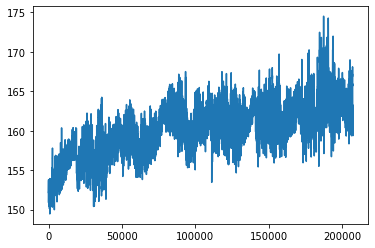

In [62]:
plt.plot(list(range(len(preds))), preds, label="Predictions")
plt.plot(list(range(len(x_avg))), x_avg.tolist(), label="Avg price")
axes = plt.gca()
axes.set_ylim([145,148])
plt.legend()
axes.set_xlim([140000,160000])
plt.show()

plt.plot(list(range(len(x_last_price))), x_last_price.tolist(), label="Last price")
plt.plot(list(range(len(test_data_y))), test_data_y.tolist(), label="Target")
plt.plot(list(range(len(preds))), preds, label="Predictions")
axes = plt.gca()
axes.set_ylim([145,148])
axes.set_xlim([159000,160000])
plt.legend()
plt.show()

plt.plot(list(range(len(preds))), preds, label="Predictions")
plt.plot(list(range(len(test_data_y))), test_data_y.tolist(), label="Target")
axes = plt.gca()
plt.legend()
plt.show()